In [45]:
import geoplot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geoplot
from geopandas import GeoDataFrame
import geodatasets
import numpy as np

In [3]:
# Import data
dirty_data = pd.read_csv("C:\\Users\\valko\\OneDrive\\Documentos\\data\\AB_NYC_2019.csv")
dirty_data.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [4]:
print(dirty_data.isna().sum())

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


In [5]:
# Clean data
data = dirty_data.drop('name', axis=1).drop("host_name", axis=1).drop("last_review", axis=1).drop("reviews_per_month", axis=1)
print(data.isna().sum())

id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64


In [6]:
data.head(10)

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
5,5099,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,129
6,5121,7356,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,1,0
7,5178,8967,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,1,220
8,5203,7490,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,1,0
9,5238,7549,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,4,188


Overall analysis of prices

In [7]:
overall_price_mean = round(data.price.mean(), 2)
overall_price_median = round(data.price.median(), 2)
overall_price_std = round(data.price.std(), 2)
print(f""" - Mean price:    ${overall_price_mean}
 - Median price:    ${overall_price_median}
 - Standard deviation: ${overall_price_std}
""")

 - Mean price:    $152.72
 - Median price:    $106.0
 - Standard deviation: $240.15



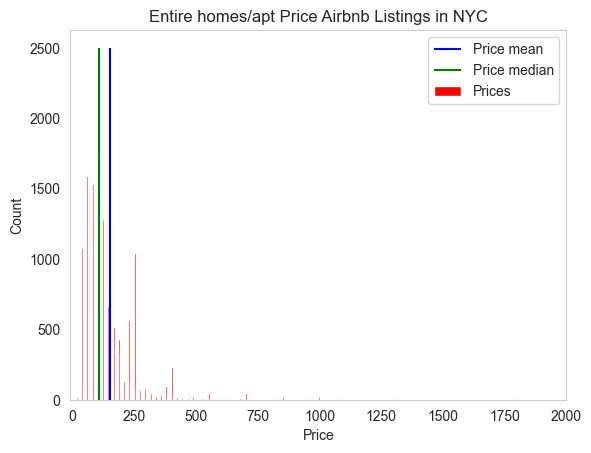

In [8]:
# Overall price visualization
plt.hist(data.price, bins=2000, color="red")
plt.title("Overall Price Airbnb Listings in NYC")
plt.vlines(x=overall_price_mean, ymin=0, ymax=2500, color="blue")
plt.vlines(x=overall_price_median, ymin=0, ymax=2500, color="green")
plt.title("Entire homes/apt Price Airbnb Listings in NYC")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend(["Price mean", "Price median", "Prices"])
plt.xlim([-10, 2000])
plt.grid()
plt.show()

### Analysis based on type of listing

In [9]:
number_of_different_type_rooms = data['room_type'].value_counts()
print(number_of_different_type_rooms)

room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64


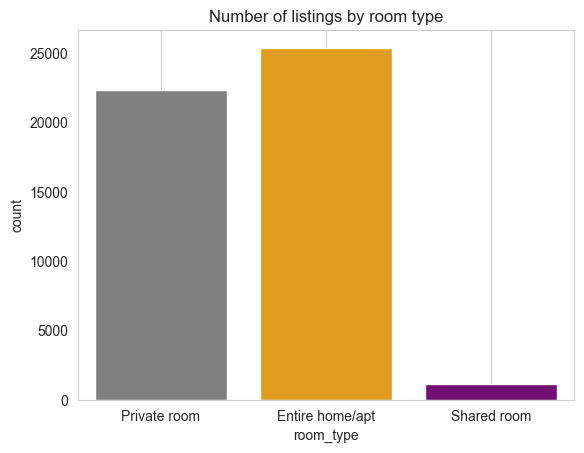

In [10]:
sns.countplot(data=data, x="room_type", hue="room_type", palette=['grey', 'orange', 'purple'], legend=False)
plt.title("Number of listings by room type")
plt.grid()

Analysis for entire homes/apartments

In [11]:
# Analysis for entire homes/apts
entire_home_price_mean = round(data.loc[data['room_type'] == "Entire home/apt", 'price'].mean(), 2)
entire_home_price_median = round(data.loc[data['room_type'] == 'Entire home/apt', 'price'].median(), 2)
entire_home_price_std = round(data.loc[data['room_type'] == 'Entire home/apt', 'price'].std(), 2)
print(f""" - Mean price:    ${entire_home_price_mean}
 - Median price:    ${entire_home_price_median}
 - Standard deviation: ${entire_home_price_std}
""")

 - Mean price:    $211.79
 - Median price:    $160.0
 - Standard deviation: $284.04



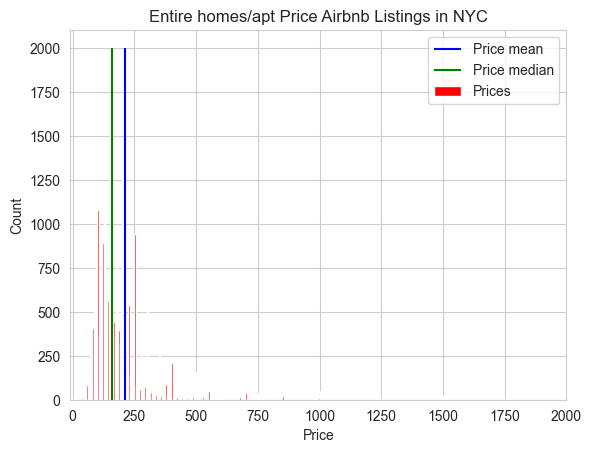

In [12]:
# Price visualization
plt.hist(data.loc[data['room_type'] == "Entire home/apt", 'price'], bins=2000, color="red")
plt.vlines(x=entire_home_price_mean, ymin=0, ymax=2000, color="blue")
plt.vlines(x=entire_home_price_median, ymin=0, ymax=2000, color="green")
plt.title("Entire homes/apt Price Airbnb Listings in NYC")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend(["Price mean", "Price median", "Prices"])
plt.xlim([-10, 2000])
plt.show()

Analysis for Private Rooms

In [13]:
private_room_price_mean = round(data.loc[data['room_type'] == "Private room", 'price'].mean(), 2)
private_room_price_median = round(data.loc[data['room_type'] == 'Private room', 'price'].median(), 2)
private_room_price_std = round(data.loc[data['room_type'] == 'Private room', 'price'].std(), 2)
print(f""" - Mean price:    ${private_room_price_mean}
 - Median price:    ${private_room_price_median}
 - Standard deviation: ${private_room_price_std}
""")

 - Mean price:    $89.78
 - Median price:    $70.0
 - Standard deviation: $160.21



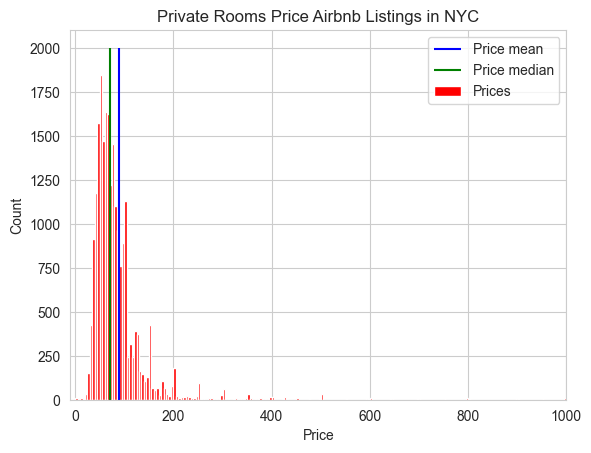

In [14]:
plt.hist(data.loc[data['room_type'] == "Private room", 'price'], bins=2000, color="red")
plt.title("Private rooms Price Airbnb Listings in NYC")
plt.vlines(x=private_room_price_mean, ymin=0, ymax=2000, color="blue")
plt.vlines(x=private_room_price_median, ymin=0, ymax=2000, color="green")
plt.title("Private Rooms Price Airbnb Listings in NYC")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend(["Price mean", "Price median", "Prices"])
plt.xlim([-10, 1000])
plt.show()

Analysis for shared rooms

In [15]:
shared_room_price_mean = round(data.loc[data['room_type'] == "Shared room", 'price'].mean(), 2)
shared_room_price_median = round(data.loc[data['room_type'] == 'Shared room', 'price'].median(), 2)
shared_room_price_std = round(data.loc[data['room_type'] == 'Shared room', 'price'].std(), 2)
print(f""" - Mean price:    ${shared_room_price_mean}
 - Median price:    ${shared_room_price_median}
 - Standard deviation: ${shared_room_price_std}
""")

 - Mean price:    $70.13
 - Median price:    $45.0
 - Standard deviation: $101.73



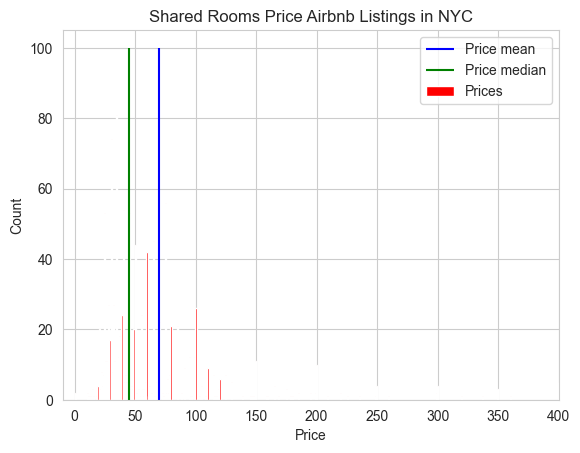

In [16]:
plt.hist(data.loc[data['room_type'] == "Shared room", 'price'], bins=2000, color="red")
plt.title("Shared rooms Price Airbnb Listings in NYC")
plt.vlines(x=shared_room_price_mean, ymin=0, ymax=100, color="blue")
plt.vlines(x=shared_room_price_median, ymin=0, ymax=100, color="green")
plt.title("Shared Rooms Price Airbnb Listings in NYC")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend(["Price mean", "Price median", "Prices"])
plt.xlim([-10, 400])
plt.show()

### Analysis based on neighbourhood

In [62]:
number_of_different_neighbourhood_groups = data['neighbourhood_group'].value_counts()
number_of_different_neighbourhood_groups

neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

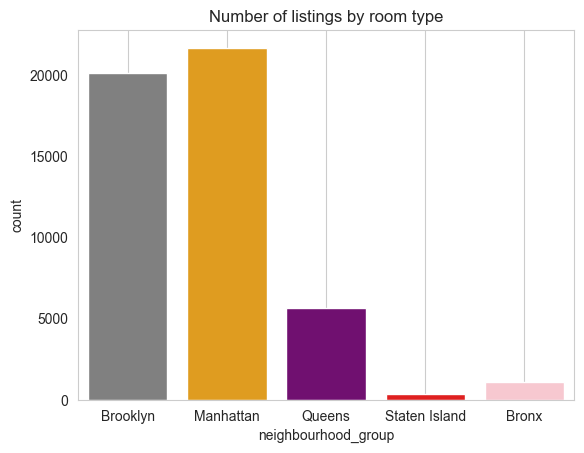

In [18]:
sns.countplot(data=data, x="neighbourhood_group", hue="neighbourhood_group", palette=['grey', 'orange', 'purple', "red", "pink"], legend=False)
plt.title("Number of listings by room type")
plt.grid()

In [19]:
Manhattan_price_mean = round(data.loc[data['neighbourhood_group'] == "Manhattan", 'price'].mean(), 2)
Manhattan_price_median = round(data.loc[data['neighbourhood_group'] == 'Manhattan', 'price'].median(), 2)
Manhattan_price_std = round(data.loc[data['neighbourhood_group'] == 'Manhattan', 'price'].std(), 2)
print(f""" - Mean price:    ${Manhattan_price_mean}
 - Median price:    ${Manhattan_price_median}
 - Standard deviation: ${Manhattan_price_std}
""")

 - Mean price:    $196.88
 - Median price:    $150.0
 - Standard deviation: $291.38



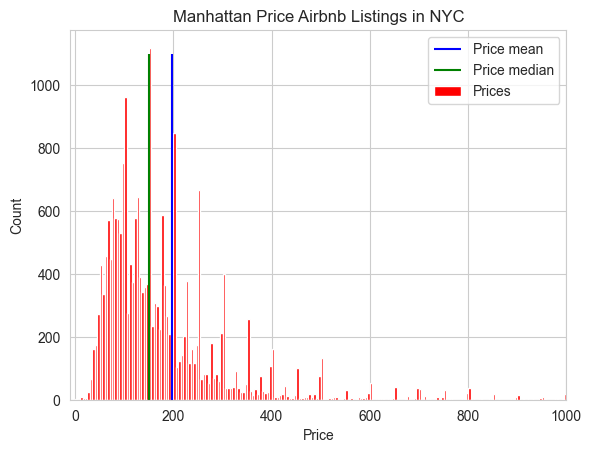

In [30]:
plt.hist(data.loc[data['neighbourhood_group'] == "Manhattan", 'price'], bins=2000, color="red")
plt.title("Manhattan Price Airbnb Listings in NYC")
plt.vlines(x=Manhattan_price_mean, ymin=0, ymax=1100, color="blue")
plt.vlines(x=Manhattan_price_median, ymin=0, ymax=1100, color="green")
plt.title("Manhattan Price Airbnb Listings in NYC")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend(["Price mean", "Price median", "Prices"])
plt.xlim([-10, 1000])
plt.show()

In [21]:
Brooklyn_price_mean = round(data.loc[data['neighbourhood_group'] == "Brooklyn", 'price'].mean(), 2)
Brooklyn_price_median = round(data.loc[data['neighbourhood_group'] == 'Brooklyn', 'price'].median(), 2)
Brooklyn_price_std = round(data.loc[data['neighbourhood_group'] == 'Brooklyn', 'price'].std(), 2)
print(f""" - Mean price:    ${Brooklyn_price_mean}
 - Median price:    ${Brooklyn_price_median}
 - Standard deviation: ${Brooklyn_price_std}
""")

 - Mean price:    $124.38
 - Median price:    $90.0
 - Standard deviation: $186.87



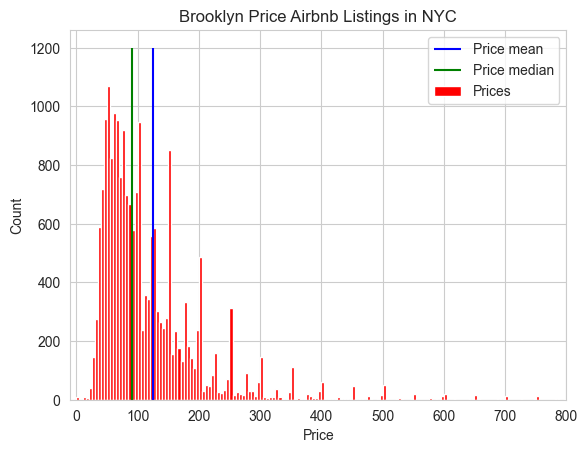

In [31]:
plt.hist(data.loc[data['neighbourhood_group'] == "Brooklyn", 'price'], bins=2000, color="red")
plt.title("Brooklyn Price Airbnb Listings in NYC")
plt.vlines(x=Brooklyn_price_mean, ymin=0, ymax=1200, color="blue")
plt.vlines(x=Brooklyn_price_median, ymin=0, ymax=1200, color="green")
plt.title("Brooklyn Price Airbnb Listings in NYC")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend(["Price mean", "Price median", "Prices"])
plt.xlim([-10, 800])
plt.show()

In [23]:
Queens_price_mean = round(data.loc[data['neighbourhood_group'] == "Queens", 'price'].mean(), 2)
Queens_price_median = round(data.loc[data['neighbourhood_group'] == 'Queens', 'price'].median(), 2)
Queens_price_std = round(data.loc[data['neighbourhood_group'] == 'Queens', 'price'].std(), 2)
print(f""" - Mean price:    ${Queens_price_mean}
 - Median price:    ${Queens_price_median}
 - Standard deviation: ${Queens_price_std}
""")

 - Mean price:    $99.52
 - Median price:    $75.0
 - Standard deviation: $167.1



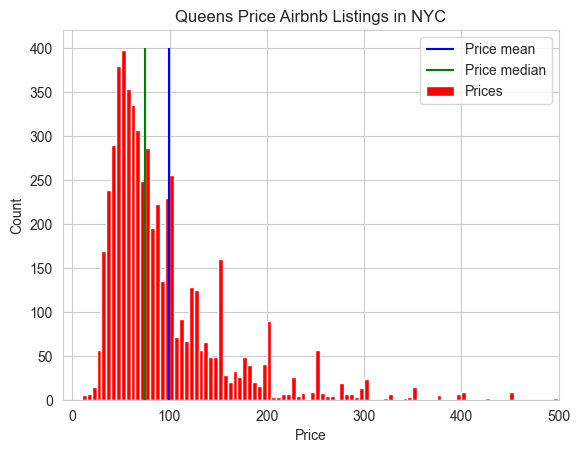

In [32]:
plt.hist(data.loc[data['neighbourhood_group'] == "Queens", 'price'], bins=2000, color="red")
plt.title("Queens Price Airbnb Listings in NYC")
plt.vlines(x=Queens_price_mean, ymin=0, ymax=400, color="blue")
plt.vlines(x=Queens_price_median, ymin=0, ymax=400, color="green")
plt.title("Queens Price Airbnb Listings in NYC")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend(["Price mean", "Price median", "Prices"])
plt.xlim([-10, 500])
plt.show()

In [33]:
Bronx_price_mean = round(data.loc[data['neighbourhood_group'] == "Bronx", 'price'].mean(), 2)
Bronx_price_median = round(data.loc[data['neighbourhood_group'] == 'Bronx', 'price'].median(), 2)
Bronx_price_std = round(data.loc[data['neighbourhood_group'] == 'Bronx', 'price'].std(), 2)
print(f""" - Mean price:    ${Bronx_price_mean}
 - Median price:    ${Bronx_price_median}
 - Standard deviation: ${Bronx_price_std}
""")

 - Mean price:    $87.5
 - Median price:    $65.0
 - Standard deviation: $106.71



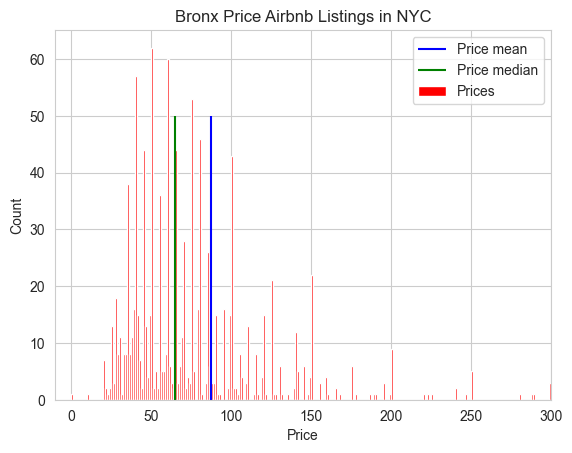

In [35]:
plt.hist(data.loc[data['neighbourhood_group'] == "Bronx", 'price'], bins=2000, color="red")
plt.title("Bronx Price Airbnb Listings in NYC")
plt.vlines(x=Bronx_price_mean, ymin=0, ymax=50, color="blue")
plt.vlines(x=Bronx_price_median, ymin=0, ymax=50, color="green")
plt.title("Bronx Price Airbnb Listings in NYC")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend(["Price mean", "Price median", "Prices"])
plt.xlim([-10, 300])
plt.show()

In [36]:
Staten_island_price_mean = round(data.loc[data['neighbourhood_group'] == "Staten Island", 'price'].mean(), 2)
Staten_island_price_median = round(data.loc[data['neighbourhood_group'] == 'Staten Island', 'price'].median(), 2)
Staten_island_price_std = round(data.loc[data['neighbourhood_group'] == 'Staten Island', 'price'].std(), 2)
print(f""" - Mean price:    ${Staten_island_price_mean}
 - Median price:    ${Staten_island_price_median}
 - Standard deviation: ${Staten_island_price_std}
""")

 - Mean price:    $114.81
 - Median price:    $75.0
 - Standard deviation: $277.62



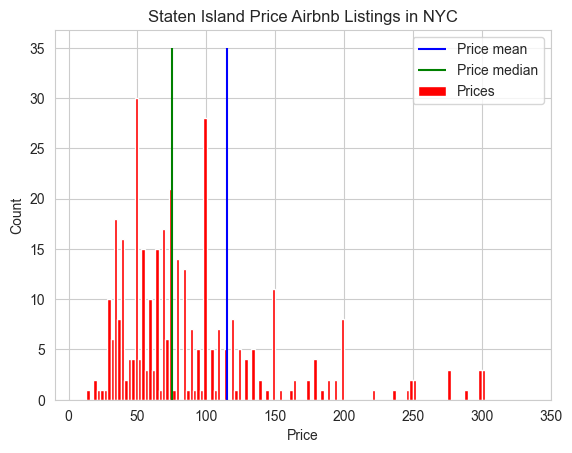

In [39]:
plt.hist(data.loc[data['neighbourhood_group'] == "Staten Island", 'price'], bins=2000, color="red")
plt.title("Staten Island Price Airbnb Listings in NYC")
plt.vlines(x=Staten_island_price_mean, ymin=0, ymax=35, color="blue")
plt.vlines(x=Staten_island_price_median, ymin=0, ymax=35, color="green")
plt.title("Staten Island Price Airbnb Listings in NYC")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend(["Price mean", "Price median", "Prices"])
plt.xlim([-10, 350])
plt.show()

In [25]:
borough_count = data.groupby('neighbourhood_group').agg('count').reset_index()
nyc = gpd.read_file(gpd.datasets.get_path(data))
nyc.rename(columns='neighbourhood_group', inplace=True)
bc_geo = nyc.merge(borough_count, on='neighbourhood_group')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
bc_geo.plot(column="id", cmap="viridis_r", ax=ax, alpha=0.5, legend=True)

# Add borough names as annotations
bc_geo.apply(lambda x: ax.annotate(
    text = x.boroname,
    color = "black",
    xy = x.geometry.centroid.coords[0],
    ha = 'center',
    fontsize = 8), 
    axis = 1)
plt.title("Number of Airbnb listings by NYC Borough")
plt.show()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [65]:
nyc_map = gpd.read_file(geodatasets.get_path("geoda.nyc"))
nyc_map
#nyc_map.plot(figsize=(8, 8), cmaps="OrRD", column=number_of_different_neighbourhood_groups)

,bor_subb,name,code,subborough,forhis06,forhis07,forhis08,forhis09,forwh06,forwh07,...,rent2008,rentpct02,rentpct05,rentpct08,pubast90,pubast00,yrhom02,yrhom05,yrhom08,geometry
0,501,North Shore,501,North Shore,37.0657,34.0317,27.3767,29.3091,13.2540,11.8768,...,1000,21.1119,24.8073,28.5344,47.329128,6.005791,10.805068,12.127853,11.547433,"POLYGON ((962498.866 175588.946, 962914.98 175..."
1,502,Mid-Island,502,Mid-Island,27.9822,18.1193,24.0452,31.1566,20.0616,19.8575,...,950,32.3615,27.2584,27.9567,35.182323,2.287034,15.241246,15.183111,14.682124,"MULTIPOLYGON (((928296.856 163214.206, 928736...."
2,503,South Shore,503,South Shore,10.7019,12.1404,9.6890,14.6638,10.3060,12.7699,...,800,23.0547,20.4146,18.1590,23.894043,1.350208,12.704250,12.972280,13.561487,"MULTIPOLYGON (((932416.259 149575.995, 933217...."
3,401,Astoria,401,Astoria,52.0961,53.9585,54.6968,47.8050,38.3658,35.6551,...,1400,25.6022,26.7685,28.0467,80.533928,5.204510,12.839167,13.377513,12.544640,"MULTIPOLYGON (((1010873.21 226064.189, 1010878..."
4,402,Sunnyside / Woodside,402,Sunnyside/Woodside,62.7242,69.3969,67.0897,58.2963,37.0512,31.9057,...,1400,18.8079,22.6752,21.3009,75.516866,2.974139,15.387656,12.518789,12.666909,"POLYGON ((1011646.607 216285.604, 1011729.063 ..."
5,403,Jackson Heights,403,Jackson Heights,68.4834,68.5405,66.5080,69.1580,34.3999,38.2428,...,1100,34.0156,34.8050,27.1032,66.642281,5.332569,12.649229,12.580355,11.965980,"MULTIPOLYGON (((1014789.93 220797.982, 1014622..."
6,404,Elmhurst / Corona,404,Elmhurst/Corona,69.5219,66.8795,69.3414,64.3005,40.3935,51.6376,...,1300,26.7381,34.3842,28.8255,77.530801,6.029230,11.554984,9.828084,10.738053,"MULTIPOLYGON (((1018353.243 205630.094, 101829..."
7,405,Middle Village / Ridgewood,405,Middle Village/Ridgewood,39.4185,35.9546,36.2750,35.0181,37.8097,34.0156,...,1100,41.2035,40.6256,36.2956,59.017019,3.951290,13.498408,12.616178,11.191645,"POLYGON ((1013477.142 206918.569, 1013729.105 ..."
8,406,Forest Hills / Rego Park,406,Rego Park/Forest Hills,58.5388,52.6183,42.3878,47.9795,43.7395,47.5873,...,1400,11.9766,10.4943,11.5520,64.162134,3.111417,13.401562,13.375477,12.742296,"POLYGON ((1026974.169 207617.321, 1027033.301 ..."
9,407,Flushing / Whitestone,407,Flushing/Whitestone,59.4432,53.4747,53.2531,57.9868,26.5802,25.6864,...,1200,23.9394,23.3487,22.6715,53.629649,2.795721,14.011260,12.806067,12.848001,"POLYGON ((1034250.672 230784.278, 1036136.389 ..."
